#### Introduction

Aqueous solubility is a key factor in drug discovery.  If a compound is not soluble, it will typically be poorly bioavailable, making it difficult to use in in-vivo studies, and ultimately to deliver to patients.

Why:: This idea for this notebook was inspired by the excellent blog post by [Pat Walters](http://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html) where he reproduced the linear regression model with similar degree of performance as that of Delaney. This example is also briefly described in the book **Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More**.

#### Import Required Library

In [51]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('delaney.csv')
data

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


#### Check the SMILES data
Chemical structures are encoded by a string of text known as SMILES which is an acronym for Simplified Molecular-Input Line-Entry System.

In [4]:
data.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

#### Convert molecules from SMILES string to an rdkit object

In [6]:
mol_list = [Chem.MolFromSmiles(element) for element in data.SMILES]

In [7]:
len(mol_list)

1144

#### Calculate molecular descriptors
To predict LogS (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:

cLogP (Octanol-water partition coefficient)
MW (Molecular weight)
RB (Number of rotatable bonds)
AP (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)
Unfortunately, rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.

In [10]:
def generate(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1,1)
    i = 0
    for mol in moldata:

        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)

        row = np.array([desc_MolLogP, desc_MolWt,desc_NumRotatableBonds])

        if(i ==0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i = i + 1
    columnNames = ['MolLogP', 'MolWt', 'NumRotatableBonds']
    descriptors = pd.DataFrame(data = baseData, columns = columnNames)

    return descriptors

In [11]:
df = generate(data.SMILES)

In [12]:
df

,MolLogP,MolWt,NumRotatableBonds
0,2.59540,167.850,0.0
1,2.37650,133.405,0.0
2,2.59380,167.850,1.0
3,2.02890,133.405,1.0
4,2.91890,187.375,1.0
...,...,...,...
1139,1.98820,287.343,8.0
1140,3.42130,286.114,2.0
1141,3.60960,308.333,4.0
1142,2.56214,354.815,3.0


#### Aromatice proportion
Here, we will create a custom function to calculate the Number of aromatic atoms. With this descriptor we can use it to subsequently calculate the AP descriptor

In [13]:
def AromaticAtoms(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aa_count = []
    for i in aromatic_atoms:
        if i == True:
            aa_count.append(1)
    sum_aa_count = sum(aa_count)
    return sum_aa_count  

In [16]:
desc_AromaticAtoms = [AromaticAtoms(element) for element in mol_list]

#### Number of heavy atoms

In [20]:
desc_HeavyAtomCount = [Descriptors.HeavyAtomCount(element) for element in mol_list]

#### Computing the Aromatic Proportion(AP) descriptor

In [21]:
desc_AromaticProportion = [AromaticAtoms(element)/Descriptors.HeavyAtomCount(element) for element in mol_list]

In [23]:
df_desc_AromaticProportion = pd.DataFrame(desc_AromaticProportion, columns = ['AromaticProportion'])

#### X matrix (Combining all computed descriptros into 1 dataframe)

In [26]:
X = pd.concat([df, df_desc_AromaticProportion],axis=1)

#### Y matrix

In [27]:
data.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [30]:
Y = data.iloc[:,1]

#### Data split

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

#### Linear Regression Model

In [35]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

#### Predict the X_train

In [36]:
Y_pred_train = model.predict(X_train)

In [39]:
print("Coefficients:", model.coef_)
print("Intercept:",model.intercept_)
print("Mean squared error (MSE): %.2f" % mean_squared_error(Y_train, Y_pred_train))
print("Coefficient of determination (R^2): %.2f"%r2_score(Y_train, Y_pred_train))

Coefficients: [-0.73797197 -0.00665581 -0.00894854 -0.47721729]
Intercept: 0.30399981783986396
Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


#### Predicts the X_test

In [40]:
Y_pred_test = model.predict(X_test)

In [43]:
print("Coefficients:",model.coef_)
print("Intercept:",model.intercept_)
print("Mean Squared error (MSE): %.2f"% mean_squared_error(Y_test, Y_pred_test))
print("Coefficeint of determination (R^2):%.2f"% r2_score(Y_test, Y_pred_test))

Coefficients: [-0.73797197 -0.00665581 -0.00894854 -0.47721729]
Intercept: 0.30399981783986396
Mean Squared error (MSE): 1.01
Coefficeint of determination (R^2):0.76


#### Linear regression equation

In [44]:
print("LogS- %.2f %.2f LogP %.4f MW %.4f RV %.2f AP" % (model.intercept_, model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3]))

LogS- 0.30 -0.74 LogP -0.0067 MW -0.0089 RV -0.48 AP


#### Use the entire dataset for model training

In [45]:
full = linear_model.LinearRegression()
full.fit(X,Y)

LinearRegression()

In [46]:
full_pred = model.predict(X)

In [47]:
print("Coefficients:", full.coef_)
print("Intercept:", full.intercept_)
print("Mean Squared Error (MSE): %.2f" % mean_squared_error(Y, full_pred))
print("Coefficient of determination (R^2): %.2f" % r2_score(Y, full_pred))

Coefficients: [-0.74173609 -0.00659927  0.00320051 -0.42316387]
Intercept: 0.25650068309972074
Mean Squared Error (MSE): 1.01
Coefficient of determination (R^2): 0.77


In [48]:
full_yintercept = "%.2f" % full.intercept_
full_LogP = "%.2f LogP" % full.coef_[0]
full_MW = "%.4f MW" % full.coef_[1]
full_RB = "+ %.4f RB" % full.coef_[2]
full_AP = "%.2f AP" % full.coef_[3]

In [50]:
print("LogS = " +
        " "+
        full_yintercept +
        " "+
        full_LogP +
        " " +
        full_RB +
        " " +
        full_AP


)

LogS =  0.26 -0.74 LogP + 0.0032 RB -0.42 AP


#### Scatter plot of experimental vs. predicted LogS

In [52]:
Y_train.shape, Y_pred_train.shape

((915,), (915,))

In [53]:
Y_test.shape, Y_pred_test.shape

((229,), (229,))

#### Vertical Plot

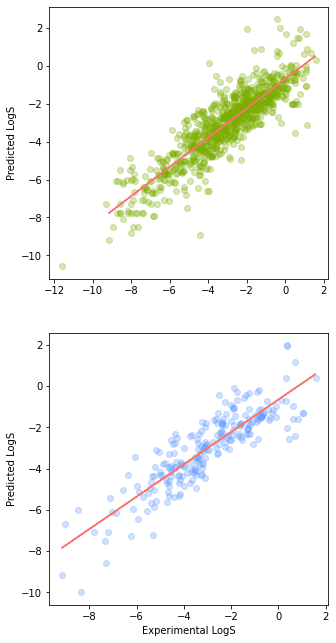

In [57]:
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c = "#7CAE00", alpha =0.3)

# Add trendline

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#F8766D")
plt.ylabel("Predicted LogS")


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c = "#619CFF", alpha=0.3)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test, p(Y_test), "#F8766D")

plt.ylabel("Predicted LogS")
plt.xlabel("Experimental LogS")

plt.savefig('plot_vertical_logS.png')
plt.savefig('plot_vertical_LogS.pdf')
plt.show()

#### Conclusion

From the coefficeint of determination(0.7), we can infer that ther is a strong correlation between the dependent and independent variables. 